In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
import nltk

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from catboost import CatBoostClassifier

nltk.download('stopwords', quiet=True)
warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED); np.random.seed(SEED)

In [2]:
# -------------------- Load data --------------------
train_df = pd.read_excel("../Datasets/Train.xlsx")
test_df  = pd.read_excel("../Datasets/Test.xlsx")

print("Train shape:", train_df.shape)
print("Test  shape :", test_df.shape)
print(train_df["Expected Operation by Developer"].value_counts())

Train shape: (931, 2)
Test  shape : (234, 2)
Expected Operation by Developer
insert     322
delete     309
replace    300
Name: count, dtype: int64


In [3]:
# -------------------- Split --------------------
X = train_df["Review Comment"]
y = train_df["Expected Operation by Developer"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.10, random_state=SEED, stratify=y
)

print("Train size:", len(X_train), "   Val size:", len(X_val))

Train size: 837    Val size: 94


In [6]:
# -------------------- Pipeline w/ CatBoost --------------------
base_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1, 2),
        min_df=2
    )),
    ("clf", CatBoostClassifier(
        loss_function="MultiClass",
        task_type="GPU",
        devices='0', 
        random_seed=SEED,
        verbose=False,          # silence training logs
        thread_count=-1
    ))
])

param_grid = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 2, 3],
    "clf__iterations": [300, 500],
    "clf__learning_rate": [0.05, 0.1, 0.2],
    "clf__depth": [4, 6, 8]
}

search = GridSearchCV(
    base_pipeline,
    param_grid,
    cv=5,
    n_jobs=1,
    scoring="accuracy",
    verbose=1
)
search.fit(X_train, y_train)

print("Best CV-accuracy:", search.best_score_)
print("Best params:", search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best CV-accuracy: 0.5591246079270031
Best params: {'clf__depth': 4, 'clf__iterations': 500, 'clf__learning_rate': 0.2, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}


In [7]:
best_pipeline = search.best_estimator_
best_pipeline.fit(X, y)      # retrain on full training data

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x7a940c38e920>)])

In [8]:
# -------------------- Test evaluation --------------------
X_test  = test_df["Review Comment"]
y_test  = test_df["Expected Operation by Developer"]

y_pred  = best_pipeline.predict(X_test)
acc     = accuracy_score(y_test, y_pred)

print(f"Test accuracy: {acc:.4f}\n")
print("Classification report:\n", classification_report(y_test, y_pred))

Test accuracy: 0.6368

Classification report:
               precision    recall  f1-score   support

      delete       0.67      0.54      0.60        78
      insert       0.58      0.77      0.66        81
     replace       0.69      0.60      0.64        75

    accuracy                           0.64       234
   macro avg       0.65      0.63      0.63       234
weighted avg       0.65      0.64      0.63       234



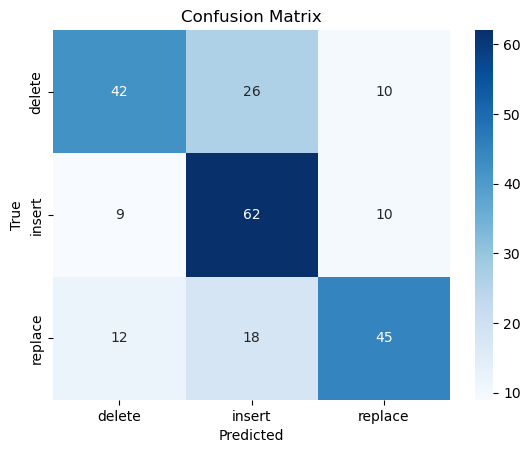

In [9]:
# -------------------- Confusion matrix --------------------
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

In [10]:
# -------------------- Top informative terms --------------------
def show_top_weights(model, n=15):
    clf   = model.named_steps["clf"]
    tfidf = model.named_steps["tfidf"]
    feature_names = np.array(tfidf.get_feature_names_out())

    importances = clf.get_feature_importance(type="FeatureImportance")
    top = np.argsort(importances)[-n:]
    print("\nTop informative terms:")
    print(", ".join(feature_names[top]))

show_top_weights(best_pipeline, n=15)


Top informative terms:
better, don, change, value, removed, previous, struct, need, just, use, needed, space, instead, add, remove
